In [59]:
import pandas as pd
import random

In [58]:
TOTAL_RESOURCES = 48
TOTAL_TASKS = 300

skills = ["python", "sql", "testing", "ml", "frontend"]

In [46]:
resources = []

for i in range(1, TOTAL_RESOURCES + 1):
    start_hour = random.randint(8, 11)
    end_hour = random.randint(start_hour + 6, 20)

    resources.append({
        "resource_id": f"R{i}",
        "skill": random.choice(skills),
        "available_from": f"{start_hour}:00",
        "available_to": f"{end_hour}:00"
    })

resources_df = pd.DataFrame(resources)
resources_df.head()

,resource_id,skill,available_from,available_to
0,R1,frontend,10:00,19:00
1,R2,ml,10:00,16:00
2,R3,testing,11:00,20:00
3,R4,testing,11:00,17:00
4,R5,testing,10:00,16:00


In [47]:
tasks = []

for i in range(1, TOTAL_TASKS + 1):
    start = random.randint(8, 17)
    duration = random.randint(1, 3)

    tasks.append({
        "task_id": f"T{i}",
        "required_skill": random.choice(skills),
        "start_time": f"{start}:00",
        "end_time": f"{start + duration}:00",
        "priority": random.randint(1, 5)
    })

tasks_df = pd.DataFrame(tasks)
tasks_df.head()

,task_id,required_skill,start_time,end_time,priority
0,T1,testing,17:00,20:00,3
1,T2,python,12:00,15:00,3
2,T3,frontend,10:00,13:00,4
3,T4,ml,14:00,16:00,4
4,T5,testing,14:00,17:00,3


In [48]:
edge_cases = [
    {"task_id": "T999", "required_skill": "devops", "start_time": "22:00", "end_time": "23:00", "priority": 1},
    {"task_id": "T1000", "required_skill": "python", "start_time": "15:00", "end_time": "13:00", "priority": 2},
    {"task_id": "T1001", "required_skill": "cloud", "start_time": "10:00", "end_time": "11:00", "priority": 3},
]

tasks_df = pd.concat([tasks_df, pd.DataFrame(edge_cases)], ignore_index=True)
tasks_df.tail()

,task_id,required_skill,start_time,end_time,priority
298,T299,frontend,14:00,16:00,4
299,T300,frontend,11:00,13:00,5
300,T999,devops,22:00,23:00,1
301,T1000,python,15:00,13:00,2
302,T1001,cloud,10:00,11:00,3


In [49]:
resources_df.to_csv("resources.csv", index=False)
tasks_df.to_csv("tasks.csv", index=False)

print("CSV files created successfully")

CSV files created successfully


In [50]:
print("Total Resources:", len(resources_df))
print("Total Tasks:", len(tasks_df))

Total Resources: 48
Total Tasks: 303


In [51]:
resources = resources_df.to_dict("records")
tasks = tasks_df.to_dict("records")

In [52]:
def is_valid_task(task, available_skills):
    try:
        start = int(task["start_time"].split(":")[0])
        end = int(task["end_time"].split(":")[0])

        if start >= end:
            return False
        if task["required_skill"] not in available_skills:
            return False
        return True
    except:
        return False

In [53]:
available_skills = set(r["skill"] for r in resources)

valid_tasks = [t for t in tasks if is_valid_task(t, available_skills)]
invalid_tasks = [t for t in tasks if t not in valid_tasks]

print("Total Tasks:", len(tasks))
print("Valid Tasks:", len(valid_tasks
print("Invalid Tasks:", len(invalid_tasks))

SyntaxError: '(' was never closed (4049413110.py, line 7)

In [ ]:
def baseline_allocate(tasks, resources):
    allocations = []
    used_resources = set()

    # Legacy system: strict limit
    MAX_RESOURCES_USED = int(0.6 * len(resources))  # 60% cap

    for task in sorted(tasks, key=lambda x: x["priority"]):
        for r in resources:
            if r["resource_id"] in used_resources:
                continue

            if r["skill"] == task["required_skill"]:
                allocations.append({
                    "task_id": task["task_id"],
                    "resource_id": r["resource_id"]
                })
                used_resources.add(r["resource_id"])
                break

        if len(used_resources) >= MAX_RESOURCES_USED:
            break

    return allocations

In [ ]:
baseline_allocations = basic_allocate(valid_tasks, resources)
print("Baseline Allocations:", len(baseline_allocations))

In [ ]:
def calculate_idle_time(resources, allocations):
    allocated = set(a["resource_id"] for a in allocations)
    idle = len(resources) - len(allocated)
    return idle

In [ ]:
baseline_idle = calculate_idle_time(resources, baseline_allocations)
print("Baseline Idle Resources:", baseline_idle)

In [ ]:
def optimized_allocate(tasks, resources):
    allocations = []
    
    # Keep track of each resource's scheduled time slots
    resource_schedule = {
        r["resource_id"]: [] for r in resources
    }

    # Sort tasks by priority, then start time
    tasks_sorted = sorted(
        tasks,
        key=lambda x: (
            x["priority"],
            int(x["start_time"].split(":")[0])
        )
    )

    for task in tasks_sorted:
        t_start = int(task["start_time"].split(":")[0])
        t_end = int(task["end_time"].split(":")[0])

        for r in resources:
            if r["skill"] != task["required_skill"]:
                continue

            r_start = int(r["available_from"].split(":")[0])
            r_end = int(r["available_to"].split(":")[0])

            if not (r_start <= t_start and r_end >= t_end):
                continue

            # Check for time overlap
            overlap = False
            for s_start, s_end in resource_schedule[r["resource_id"]]:
                if not (t_end <= s_start or t_start >= s_end):
                    overlap = True
                    break

            if not overlap:
                allocations.append({
                    "task_id": task["task_id"],
                    "resource_id": r["resource_id"]
                })
                resource_schedule[r["resource_id"]].append((t_start, t_end))
                break

    return allocations

In [ ]:
optimized_allocations = optimized_allocate(valid_tasks, resources)
print("Optimized Allocations:", len(optimized_allocations))

In [ ]:
optimized_idle = calculate_idle_time(resources, optimized_allocations)
print("Optimized Idle Resources:", optimized_idle)

In [54]:
if baseline_idle == 0:
    improvement = 0
    print("Baseline idle time is zero — percentage improvement not applicable.")
else:
    improvement = ((baseline_idle - optimized_idle) / baseline_idle) * 100

print("Baseline Idle:", baseline_idle)
print("Optimized Idle:", optimized_idle)
print(f"Idle Time Reduction: {improvement:.2f}%")

Baseline idle time is zero — percentage improvement not applicable.
Baseline Idle: 0
Optimized Idle: 0
Idle Time Reduction: 0.00%


In [60]:
def build_resource_schedule(allocations, tasks):
    schedule = {}

    task_lookup = {t["task_id"]: t for t in tasks}

    for a in allocations:
        task = task_lookup[a["task_id"]]
        start = int(task["start_time"].split(":")[0])
        end = int(task["end_time"].split(":")[0])

        schedule.setdefault(a["resource_id"], []).append((start, end))

    return schedule


In [61]:
baseline_schedule = build_resource_schedule(baseline_allocations, valid_tasks)

def calculate_idle_hours(resources, schedule):
    total_idle = 0

    for r in resources:
        r_id = r["resource_id"]
        r_start = int(r["available_from"].split(":")[0])
        r_end = int(r["available_to"].split(":")[0])

        total_available = r_end - r_start

        busy = 0
        for s, e in schedule.get(r_id, []):
            busy += (e - s)

        idle = max(total_available - busy, 0)
        total_idle += idle

    return total_idle

baseline_idle_hours = calculate_idle_hours(resources, baseline_schedule)
print("Baseline Idle Hours:", baseline_idle_hours)


Baseline Idle Hours: 287


In [62]:
optimized_schedule = build_resource_schedule(optimized_allocations, valid_tasks)
optimized_idle_hours = calculate_idle_hours(resources, optimized_schedule)
print("Optimized Idle Hours:", optimized_idle_hours)

Optimized Idle Hours: 74


In [63]:
if baseline_idle_hours == 0:
    print("No idle hours in baseline — system fully utilized.")
else:
    improvement = (
        (baseline_idle_hours - optimized_idle_hours)
        / baseline_idle_hours
    ) * 100

    print(f"Idle Time Reduction: {improvement:.2f}%")

Idle Time Reduction: 74.22%


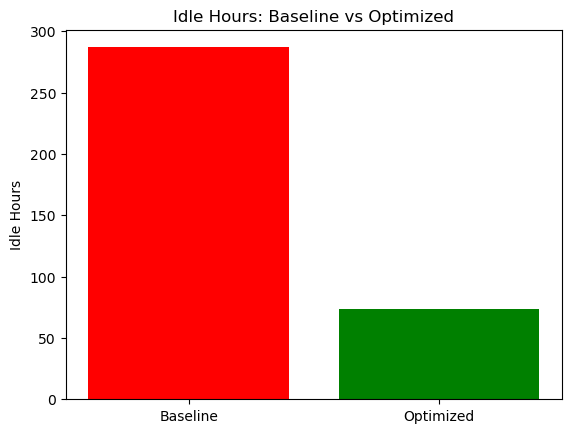

In [64]:
import matplotlib.pyplot as plt

labels = ["Baseline", "Optimized"]
values = [baseline_idle_hours, optimized_idle_hours]

plt.bar(labels, values, color=['red','green'])
plt.title("Idle Hours: Baseline vs Optimized")
plt.ylabel("Idle Hours")
plt.show()